# 3: Build a feed forward neural network

In [1]:
from modules.utils import *

import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model 
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPool1D, Flatten, Input, concatenate, Dropout, Activation, regularizers, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
print('TF version:',tf.__version__)

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import classification_report,accuracy_score, roc_auc_score, confusion_matrix

Using TensorFlow backend.


TF version: 1.15.0


In [2]:
cwd = os.getcwd()
print(cwd)
os.chdir(cwd)

RESULT_PATH = './results'
if not os.path.exists(RESULT_PATH):
        os.mkdir(RESULT_PATH)
print(RESULT_PATH)

C:\Users\brizio\Documents\PythonNB\FICOchallenge
./results


## Load prepped data
- Normal Scaling of numeric variables: f_load_data(1)
- Binning (following Rudin) and one hot encoding: f_load_data(2)
- Binning and applying WOE, calculating WOE on Rudin's bins: f_load_data(3)
- Binning and applying WOE, following Rudin: f_load_data(4)

In [16]:
data, X1, y, y_onehot = f_load_data(1)
X_train, X_test, y_train, y_test = train_test_split(X1, y_onehot, test_size = .25, random_state = 2020, shuffle = True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X1.head()

Normal Scaling of numeric variables (prep_option = 1)
Target: Bad (y=1)
Bad     5459
Good    5000
Name: RiskPerformance, dtype: int64
[[   0 5000]
 [   1 5459]]
X shape: (10459, 23)
(7844, 23) (2615, 23) (7844, 1) (2615, 1)


,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,MaxDelq2PublicRecLast12M,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,-0.588324,-0.366575,-0.341585,0.261899,0.043983,1.176415,0.060341,-0.140837,-0.232309,-0.513377,...,0.538241,0.053626,-0.273077,-0.258498,0.045581,-1.120175,1.091102,0.005886,0.292417,0.249757
1,-0.304241,-1.150684,0.485414,-0.846892,-1.340237,1.574221,1.750041,0.513051,-0.671328,-1.312078,...,1.730629,0.053626,-0.273077,-0.258498,-1.052271,-1.120175,-0.721739,-2.210425,-2.387770,-2.240297
2,-0.020158,-1.077744,-0.266403,-1.285252,-0.801929,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,0.587924,0.053626,0.985121,1.013949,0.710946,0.637562,0.184681,0.252143,0.292417,0.863249
3,-0.067506,-0.138636,-0.567130,-0.021745,0.659193,0.380804,0.482766,0.243803,3.377399,0.285325,...,1.233801,0.053626,1.299670,1.013949,1.343042,1.041366,0.637892,0.744657,0.888014,1.043688
4,0.642701,1.356643,1.387594,1.499621,-0.571226,-0.017002,0.060341,0.513051,-0.671328,0.551559,...,-0.356050,0.053626,0.041473,0.059614,0.644409,1.183886,-0.041924,0.005886,-0.005381,0.646722


## Model Loading and/or Training

In [42]:
# Model Creation

def get_FFNN_model(X, y, hidden_layers_size = [4]):
    """
        BASIC MODEL for the FF-NN
    """
    input_size = len(X.columns.values)
    output_size = len(y.columns.values)
    
    if len(hidden_layers_size) == 0:
        # No hidden layer (linear regression equivalent)
        ff_layers = [ Dense(output_size, input_shape=(input_size,), activation='softmax') ]
    else:
        ff_layers = [
            tf.keras.layers.Dense(hidden_layers_size[0], input_shape=(input_size,), activation=ACTIVATION,
                  kernel_initializer='he_uniform'
#                   bias_initializer = 'zeros',
                ## specific layer regularizer
#                   kernel_regularizer=regularizers.l1(0.001)
#                   ,activity_regularizer=regularizers.l2(0.001)
                 ),
            ## batch normalisation
#             tf.keras.layers.BatchNormalization(),  # <- Batch normalisation layer
            ## dropout
#             Dropout(0.3),
            ## elastic regularization
#             Dense(hidden_layers_size[0], input_shape=(input_size,), activation='sigmoid', activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
            tf.keras.layers.Dense(output_size, activation='sigmoid') 
        ]
          
            
    print(ff_layers)
    model = tf.keras.models.Sequential(ff_layers)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=L_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy','AUC',recall_m,precision_m,f1_m])
    model.summary()
    return model

# Model Training

def net_train(model, bestmodel_path, X_train, y_train_onehot, X_validate, y_validate_onehot, epochs, save_model, VERBOSE):
    # Define four callbacks to use
    checkpointer = ModelCheckpoint(filepath = bestmodel_path, verbose = VERBOSE, save_best_only = True, save_weights_only=False)
    early_stopping = EarlyStopping(monitor = 'val_acc', mode = 'max', patience = PATIENCE)
    learning_rate_reduction = ReduceLROnPlateau(monitor = 'loss', factor = 0.1, patience = 20, verbose = VERBOSE)

    # Train the model
    if save_model:
        history = model.fit(X_train, y_train_onehot, verbose = VERBOSE, epochs=epochs, batch_size=BATCH_SIZE, 
                            callbacks=[
                                checkpointer,
                                early_stopping, 
                                learning_rate_reduction
                            ], 
    #                         validation_data=(X_validate, y_validate_onehot)
                            validation_split = 0.2
                           )
    else:
        history = model.fit(X_train, y_train_onehot, verbose = VERBOSE, epochs=epochs, batch_size=BATCH_SIZE, 
                            callbacks=[
                                early_stopping, 
                                learning_rate_reduction
                            ], 
                            validation_split = 0.2
                           )        

    return history

[<tensorflow.python.keras.layers.core.Dense object at 0x000001838638C408>, <tensorflow.python.keras.layers.core.Dense object at 0x000001838C08F488>]
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 10)                240       
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________
Train on 6694 samples, validate on 1674 samples
Epoch 1/500

Epoch 00001: val_loss improved from inf to 0.56627, saving model to ./results\FF_ori_ep500_pa500_bs8_hs[10]_lr_0.001_relu
6694/6694 - 3s - loss: 0.6168 - acc: 0.6612 - auc_32: 0.7215 - recall_m: 0.6987 - precision_m: 0.6735 - f1_m: 0.6580 - val_loss: 0.5663 - val_acc: 0.7168 - val_auc_32: 0.7855 - val_reca

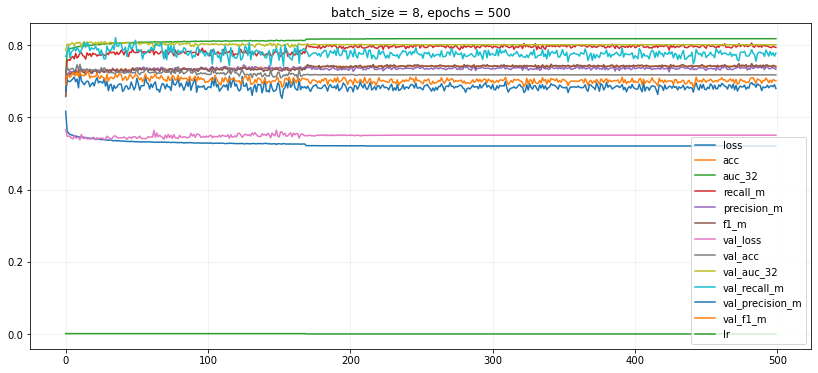

In [43]:
base_model_name = "FF_ori"
EPOCHS = 200
PATIENCE = 200
BATCH_SIZE = 8
HIDDEN_LAYERS = [10]
ACTIVATION = 'relu'
L_RATE = 0.001
model_name = '{}_ep{}_pa{}_bs{}_hs{}_lr_{}_{}'.format(base_model_name,EPOCHS,PATIENCE,BATCH_SIZE,HIDDEN_LAYERS,L_RATE,ACTIVATION)
model_name
model = get_FFNN_model(X_train, y_onehot, HIDDEN_LAYERS)

model_path = os.path.join(RESULT_PATH, model_name)

forge_gen = True

if not os.path.exists(model_path) or forge_gen:
    history = net_train(model, model_path, X_train, y_train, X_test, y_test, EPOCHS, save_model=True, VERBOSE=2)    
    
    score = model.evaluate(X_test, y_test)
    plt.figure(figsize=(14,6))
    for key in history.history.keys():
        plt.plot(history.history[key], label=key)
    plt.legend(loc='best')
    plt.grid(alpha=.2)
    plt.title(f'batch_size = {BATCH_SIZE}, epochs = {EPOCHS}')
    plt.draw()
else:
    print('Model loaded.')
    model.load_weights(model_path)

In [44]:
# scores = model.evaluate(X_onehot_train.values, y_onehot_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print("Training Set:", "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# scores = model.evaluate(X_onehot_test.values, y_onehot_test)
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Test Set:", "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

confusion_matrix(y_test, model.predict_classes(X_test), sample_weight=None)

Training Set: 
acc: 73.75%
Test Set: 
acc: 72.81%


array([[ 808,  416],
       [ 295, 1096]], dtype=int64)

### 5-fold crossvalidation

In [45]:
run_kf = True
if run_kf:
    n_folds = 5
    kf = KFold(n_splits = n_folds, random_state = 1, shuffle = True)
    
    fold = 0
    result_metrics_list = []
    for train_idx, val_idx in kf.split(X1):
        fold += 1
        print(fold)
        X_train = X1.iloc[train_idx]
        y_train = y_onehot.iloc[train_idx]
        X_val = X1.iloc[val_idx]
        y_val = y_onehot.iloc[val_idx]

        model = get_FFNN_model(X_train, y_train, HIDDEN_LAYERS)
        history = net_train(model, model_path, X_train, y_train, X_val, y_val, EPOCHS, save_model=False, VERBOSE=False)    
        score = model.evaluate(X_val, y_val)
      
        result_metrics_list.append([score])
        
    print("\033[1m")
    print("Mean Accuracy= ","{:.4}".format(np.mean(result_metrics_list,axis=0)[0][1]),", Sd= ","{:.2}".format(np.std(result_metrics_list,axis=0)[0][1]))
    print("Mean AUC= ","{:.4}".format(np.mean(result_metrics_list,axis=0)[0][2]),", Sd= ","{:.2}".format(np.std(result_metrics_list, axis=0)[0][2]))
    print("\033[0m")


1
[<tensorflow.python.keras.layers.core.Dense object at 0x00000183886EF288>, <tensorflow.python.keras.layers.core.Dense object at 0x000001838C4EC288>]
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 10)                240       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________
2092/2092 [==============================] - 0s 38us/sample - loss: 0.5592 - acc: 0.7247 - auc_34: 0.7910 - recall_m: 0.7631 - precision_m: 0.6984 - f1_m: 0.7196
2
[<tensorflow.python.keras.layers.core.Dense object at 0x000001838C4E8F48>, <tensorflow.python.keras.layers.core.Dense object at 0x000001838F7A5DC8>]
Model: "sequential_20"
______________________________

## Load prepped data (WoE from Rudin)
- Normal Scaling of numeric variables: f_load_data(1)
- Binning (following Rudin) and one hot encoding: f_load_data(2)
- Binning and applying WOE, calculating WOE on Rudin's bins: f_load_data(3)
- Binning and applying WOE, following Rudin: f_load_data(4)

In [46]:
data, X1, y, y_onehot = f_load_data(4)
X_train, X_test, y_train, y_test = train_test_split(X1, y_onehot, test_size = .25, random_state = 2020, shuffle = True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X1.head()

Binning and applying WOE, following Rudin (prep_option = 4)
Target: Bad (y=1)
Bad     5459
Good    5000
Name: RiskPerformance, dtype: int64
[[   0 5000]
 [   1 5459]]
X shape: (10459, 23)
(7844, 23) (2615, 23) (7844, 1) (2615, 1)


,ExternalRiskEstimate_bin_WOE,MSinceOldestTradeOpen_bin_WOE,MSinceMostRecentTradeOpen_bin_WOE,AverageMInFile_bin_WOE,NumSatisfactoryTrades_bin_WOE,NumTrades60Ever2DerogPubRec_bin_WOE,NumTrades90Ever2DerogPubRec_bin_WOE,NumTotalTrades_bin_WOE,NumTradesOpeninLast12M_bin_WOE,PercentTradesNeverDelq_bin_WOE,...,PercentInstallTrades_bin_WOE,NetFractionInstallBurden_bin_WOE,NumInstallTradesWBalance_bin_WOE,MSinceMostRecentInqexcl7days_bin_WOE,NumInqLast6M_bin_WOE,NumInqLast6Mexcl7days_bin_WOE,NetFractionRevolvingBurden_bin_WOE,NumRevolvingTradesWBalance_bin_WOE,NumBank2NatlTradesWHighUtilization_bin_WOE,PercentTradesWBalance_bin_WOE
0,1.799,0.086,0.083,0.269,0.166,0.952,-0.021,-0.097,-0.021,1.012,...,-0.503,0.047,0.242,1.223,-0.047,-0.051,-0.088,0.034,-0.601,-0.130
1,1.799,0.549,0.083,1.238,1.999,0.952,-0.053,0.535,-0.021,-0.147,...,0.161,0.047,0.256,1.223,-0.047,-0.051,-0.739,-0.188,0.601,-0.982
2,1.017,0.549,0.083,1.238,0.539,-0.021,-0.021,0.535,0.428,-0.147,...,-0.503,0.147,0.242,1.223,0.170,0.021,0.633,-0.263,-0.601,0.203
3,1.017,0.086,0.083,0.269,-0.086,-0.021,-0.021,-0.377,0.287,0.366,...,-0.145,0.363,0.313,1.223,0.471,0.021,0.633,-0.150,0.541,0.772
4,-1.094,-0.148,0.000,0.000,0.539,-0.021,-0.021,0.116,-0.021,-0.147,...,-0.620,0.363,0.242,1.223,-0.047,-0.051,0.633,-0.188,-0.601,0.203


## Build same model and assess impact of woe binning

[<tensorflow.python.keras.layers.core.Dense object at 0x0000018390BAA788>, <tensorflow.python.keras.layers.core.Dense object at 0x000001838E62DE88>]
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 10)                240       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________
Train on 6275 samples, validate on 1569 samples
Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.56404, saving model to ./results\FF_WOE_ep200_pa200_bs8_hs[10]_lr_0.001_relu
6275/6275 - 4s - loss: 0.5892 - acc: 0.6872 - auc_46: 0.7531 - recall_m: 0.7429 - precision_m: 0.6546 - f1_m: 0.6678 - val_loss: 0.5640 - val_acc: 0.7004 - val_auc_46: 0.7871 - val_reca

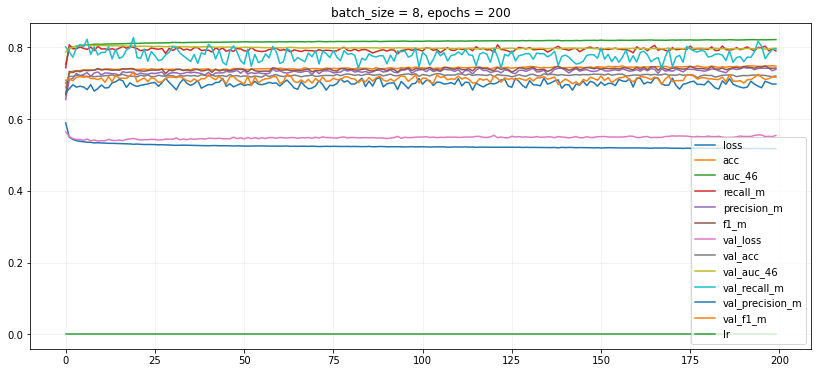

In [48]:
base_model_name = "FF_WOE"
EPOCHS = 200
PATIENCE = 200
BATCH_SIZE = 8
HIDDEN_LAYERS = [10]
ACTIVATION = 'relu'
L_RATE = 0.001
model_name = '{}_ep{}_pa{}_bs{}_hs{}_lr_{}_{}'.format(base_model_name,EPOCHS,PATIENCE,BATCH_SIZE,HIDDEN_LAYERS,L_RATE,ACTIVATION)
model_name
model = get_FFNN_model(X_train, y_onehot, HIDDEN_LAYERS)

model_path = os.path.join(RESULT_PATH, model_name)

forge_gen = True

if not os.path.exists(model_path) or forge_gen:
    history = net_train(model, model_path, X_train, y_train, X_test, y_test, EPOCHS, save_model=True, VERBOSE=2)    
    
    score = model.evaluate(X_test, y_test)
    plt.figure(figsize=(14,6))
    for key in history.history.keys():
        plt.plot(history.history[key], label=key)
    plt.legend(loc='best')
    plt.grid(alpha=.2)
    plt.title(f'batch_size = {BATCH_SIZE}, epochs = {EPOCHS}')
    plt.draw()
else:
    print('Model loaded.')
    model.load_weights(model_path)

In [49]:
# scores = model.evaluate(X_onehot_train.values, y_onehot_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print("Training Set:", "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# scores = model.evaluate(X_onehot_test.values, y_onehot_test)
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Test Set:", "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

confusion_matrix(y_test, model.predict_classes(X_test), sample_weight=None)

Training Set: 
acc: 74.21%
Test Set: 
acc: 71.63%


array([[ 780,  444],
       [ 298, 1093]], dtype=int64)

### 5-fold crossvalidation

In [ ]:
run_kf = True

In [50]:
if run_kf:
    n_folds = 5
    kf = KFold(n_splits = n_folds, random_state = 1, shuffle = True)
    
    fold = 0
    result_metrics_list = []
    for train_idx, val_idx in kf.split(X1):
        fold += 1
        print(fold)
        X_train = X1.iloc[train_idx]
        y_train = y_onehot.iloc[train_idx]
        X_val = X1.iloc[val_idx]
        y_val = y_onehot.iloc[val_idx]

        model = get_FFNN_model(X_train, y_train, HIDDEN_LAYERS)
        history = net_train(model, model_path, X_train, y_train, X_val, y_val, EPOCHS, save_model=False, VERBOSE=False)    
        score = model.evaluate(X_val, y_val)
      
        result_metrics_list.append([score])
        
    print("\033[1m")
    print("Mean Accuracy= ","{:.4}".format(np.mean(result_metrics_list,axis=0)[0][1]),", Sd= ","{:.2}".format(np.std(result_metrics_list,axis=0)[0][1]))
    print("Mean AUC= ","{:.4}".format(np.mean(result_metrics_list,axis=0)[0][2]),", Sd= ","{:.2}".format(np.std(result_metrics_list, axis=0)[0][2]))
    print("\033[0m")


1
[<tensorflow.python.keras.layers.core.Dense object at 0x000001838F983D88>, <tensorflow.python.keras.layers.core.Dense object at 0x0000018391ED7348>]
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 10)                240       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________
2092/2092 [==============================] - 0s 38us/sample - loss: 0.5595 - acc: 0.7285 - auc_48: 0.7936 - recall_m: 0.7944 - precision_m: 0.6921 - f1_m: 0.7302
2
[<tensorflow.python.keras.layers.core.Dense object at 0x0000018391ED7108>, <tensorflow.python.keras.layers.core.Dense object at 0x000001839468BA08>]
Model: "sequential_27"
______________________________

### Load Weights and Architecture

In [70]:
checkpoint_dir = os.path.join('results')
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)


None


In [53]:
new_model = load_model(checkpoint_dir,  compile=False)
new_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1),
                  loss='binary_crossentropy',
                  metrics=['accuracy',recall_m,precision_m])

def get_train_test_accuracy(model):
    # scores = model.evaluate(X_onehot_train.values, y_onehot_train)
    scores = model.evaluate(X_onehot_train, y_onehot_train, verbose=0)
    print("Training Set:", "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    # scores = model.evaluate(X_onehot_test.values, y_onehot_test)
    scores = model.evaluate(X_onehot_test, y_onehot_test, verbose = 0)
    print("Test Set:", "\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

get_train_test_accuracy(new_model)

Training Set: 
acc: 73.57%
Test Set: 
acc: 72.20%


In [100]:
baseline_model_accuracy = model.evaluate(
    X_onehot_test, y_onehot_test, verbose=0)[1]

print('Baseline test accuracy:', baseline_model_accuracy)

Baseline test accuracy: 0.72275335


### Pruning

In [104]:
run = True
if run is not None:
    import tensorflow_model_optimization as tfmot

    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    # Compute end step to finish pruning after 2 epochs.
    validation_split = .25 # 10% of training set will be used for validation set. 

    num_images = X_onehot_train.shape[0] * (1 - validation_split)
    end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * EPOCHS
    initial_sparsity = 0.001
    final_sparsity = 0.0001

    print(end_step,initial_sparsity,final_sparsity)

    # Define model for pruning.
    pruning_params = {
          'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
                                                                   final_sparsity=final_sparsity,
                                                                   begin_step=0,
                                                                   end_step=end_step)
    }

    model_for_pruning = prune_low_magnitude(model, **pruning_params)

    # `prune_low_magnitude` requires a recompile.
    model_for_pruning.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy',recall_m,precision_m])

    model_for_pruning.summary()
    
    import tempfile
    logdir = tempfile.mkdtemp()
    EPOCHS = 3


    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
      tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
    ]

    model_for_pruning.fit(X_onehot_train, y_onehot_train,
                      batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=validation_split,
                      callbacks=callbacks)
    
    # strip dropped parameters and evaluate accuracy
    model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

    model_for_export.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model_for_pruning_accuracy = model_for_export.evaluate(
       X_onehot_test, y_onehot_test, verbose=0)[1]

    print('Baseline test accuracy:', baseline_model_accuracy)
    print('Pruned test accuracy:', model_for_pruning_accuracy)

276 0.001 0.0001
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_dense_10 (None, 10)                3712      
_________________________________________________________________
prune_low_magnitude_batch_no (None, 10)                41        
_________________________________________________________________
prune_low_magnitude_dense_11 (None, 1)                 23        
Total params: 3,776
Trainable params: 1,891
Non-trainable params: 1,885
_________________________________________________________________
Train on 5883 samples, validate on 1961 samples
Epoch 1/3
5883/5883 [==============================] - 2s 260us/sample - loss: 0.6288 - acc: 0.7178 - recall_m: 0.7542 - precision_m: 0.7215 - val_loss: 0.7146 - val_acc: 0.6512 - val_recall_m: 0.9392 - val_precision_m: 0.5988
Epoch 2/3
5883/5883 [==============================] - 1s 111us/sample - loss: 0.6218 

#### Convolutional net

In [30]:
# # fit and evaluate a model
# def evaluate_model(trainX, trainy, testX, testy, n_kernel):
# 	verbose, epochs, batch_size = 1, 10, 10
# 	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
# 	model = Sequential()
# 	model.add(Conv1D(filters=10, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps,n_features)))
# # 	model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu'))
# 	model.add(Dropout(0.5))
# 	model.add(MaxPooling1D(pool_size=2))
# 	model.add(Flatten())
# 	model.add(Dense(10, activation='relu'))
# 	model.add(Dense(n_outputs, activation='softmax'))
# 	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# 	# fit network
# 	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
# 	# evaluate model
# 	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
# 	return accuracy
 
# # summarize scores
# def summarize_results(scores, params):
# 	print(scores, params)
# 	# summarize mean and standard deviation
# 	for i in range(len(scores)):
# 		m, s = mean(scores[i]), std(scores[i])
# 		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
# 	# boxplot of scores
# 	pyplot.boxplot(scores, labels=params)
# 	pyplot.savefig('exp_cnn_kernel.png')
 
# # run an experiment
# def run_experiment(params, repeats=10):
# 	# load data
# 	trainX, trainy, testX, testy = np.expand_dims(X_onehot_train,axis=2) ,y_onehot_train , np.expand_dims(X_onehot_test,axis=2) , y_onehot_test
# 	# test each parameter
# 	all_scores = list()
# 	for p in params:
# 		# repeat experiment
# 		scores = list()
# 		for r in range(repeats):
# 			score = evaluate_model(trainX, trainy, testX, testy, p)
# 			score = score * 100.0
# 			print('>p=%d #%d: %.3f' % (p, r+1, score))
# 			scores.append(score)
# 		all_scores.append(scores)
# 	# summarize results
# 	summarize_results(all_scores, params)
 
# # run the experiment
# n_params = [2]
# run_experiment(n_params)